In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_ubyte
import imageio
from enum import Enum

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from camera_visualization import plot_cameras

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

# add path for demo utils functions 
import sys
import os
import copy
sys.path.append(os.path.abspath(''))

In [2]:
def get_body_image_from_image_tensor(images: torch.tensor, body_estimation):
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)


In [3]:
ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

In [4]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "mike/pose_0_1_meshlab.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

texture_image = mesh.textures.maps_padded()
verticies = mesh.verts_list()
verticies[0].requires_grad = True

faces = mesh.faces_list()
texture = mesh.textures.clone()
maps = texture.maps_padded()
faces_uvs = texture.faces_uvs_padded()
verts_uvs = texture.verts_uvs_padded()
verts_rgb = texture.verts_rgb_padded()
new_texture = Textures(maps, faces_uvs, verts_uvs, verts_rgb)

In [5]:
new_mesh = Meshes(verticies, faces, new_texture)

In [6]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


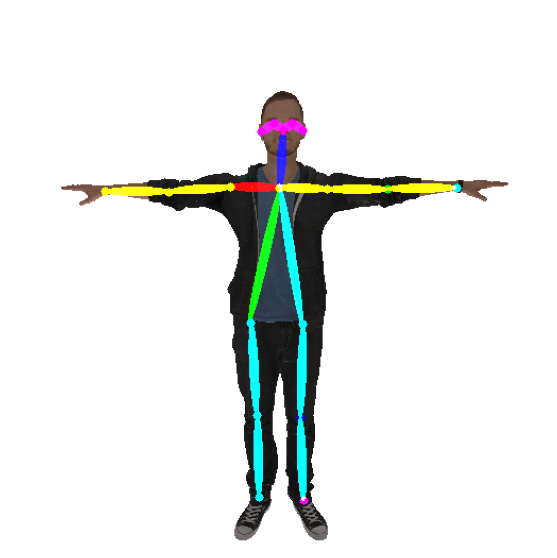

In [7]:
R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

images = renderer(new_mesh, cameras=cameras)
canvas, candidate, subset, heatmap_avg, paf_avg = get_body_image_from_image_tensor(images, body_estimation)
plt.figure(figsize=(10, 10))
plt.imshow(canvas)
plt.grid("off");
plt.axis("off");

100%|██████████| 3/3 [00:19<00:00,  6.38s/it]


(0.0, 200.0)

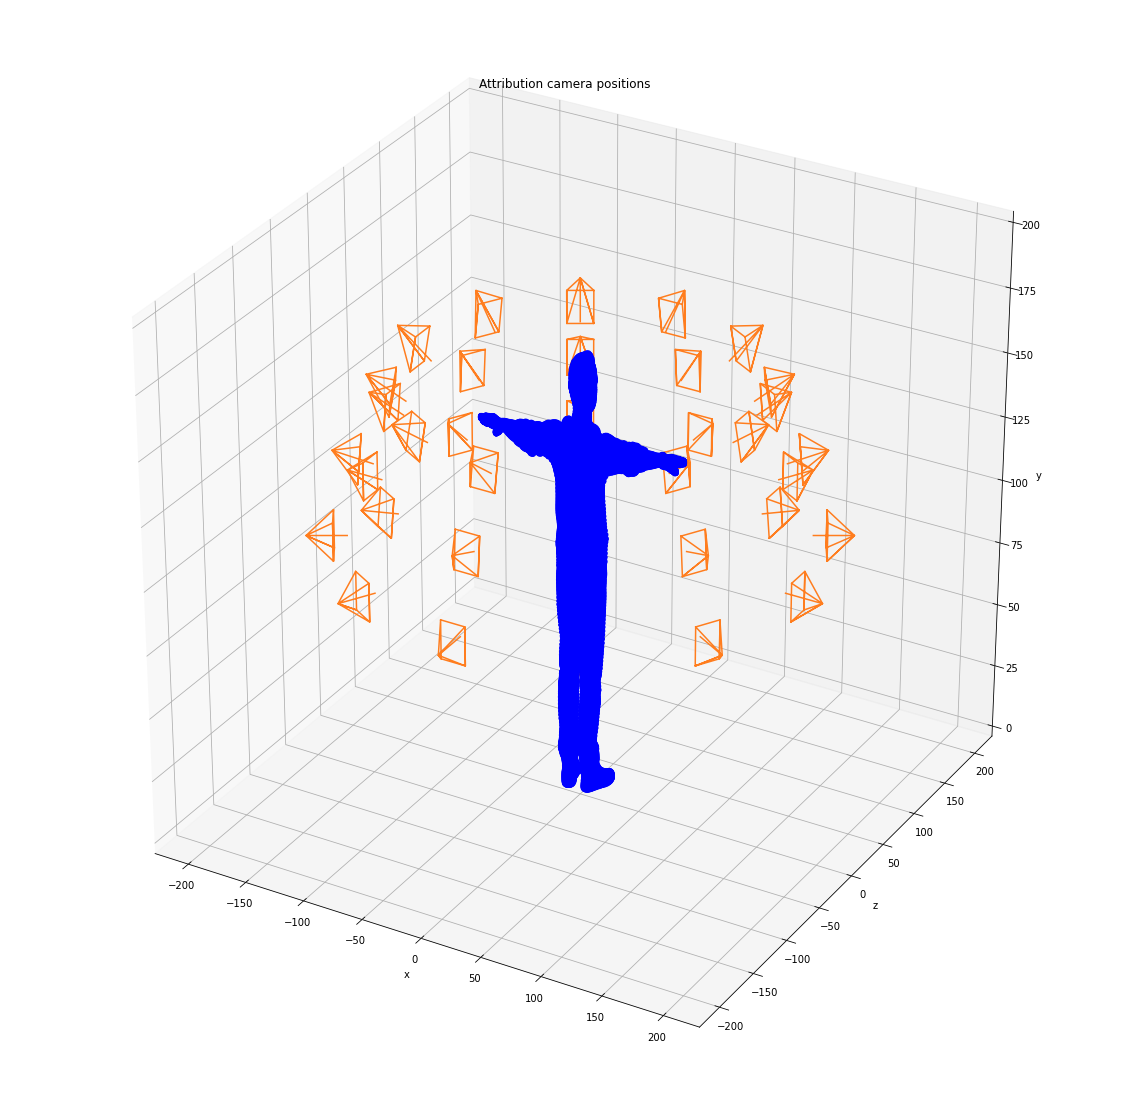

In [28]:
class CocoPart(Enum):
    Nose = 0
    Neck = 1
    RShoulder = 2
    RElbow = 3
    RWrist = 4
    LShoulder = 5
    LElbow = 6
    LWrist = 7
    RHip = 8
    RKnee = 9
    RAnkle = 10
    LHip = 11
    LKnee = 12
    LAnkle = 13
    REye = 14
    LEye = 15
    REar = 16
    LEar = 17
    Background = 18


ATTRIBUTION_PART = CocoPart.Neck
ATTRIBUTION_INDEX = ATTRIBUTION_PART.value # attribution index
ATTRIBUTION_NAME = ATTRIBUTION_PART.name # attribution index
HEATMAP_LIM = 0.1
gradients_np = []
gradients_mag_np = []
rendering_info = []

fig = plt.figure(figsize=(20, 20))
ax = fig.gca(projection="3d")
ax.clear()

ax.set_title("Attribution camera positions")

x = verticies[0][:, 0].detach().cpu().numpy()
z = verticies[0][:, 1].detach().cpu().numpy()
y = verticies[0][:, 2].detach().cpu().numpy()

ax.scatter(x, y, z, alpha=0.8, c="blue")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("y")


for elev in tqdm(range(0, 30, 10)):
    for azim in range(0, 360, 30):
    
        R, T = look_at_view_transform(200.0, elev, azim) 
        T[0, 1] = -100
        cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
        
        handle_cam = plot_cameras(ax, cameras, color="#FF7D1E", scale=10, linewidth=1.5)
        
        cur_verticies_np = mesh.verts_list()[0].detach().cpu().numpy()
        cur_verticies = [torch.from_numpy(cur_verticies_np).cuda()]
        cur_verticies[0].requires_grad = True
        new_mesh = Meshes(cur_verticies, faces, new_texture)

        images = renderer(new_mesh, cameras= cameras)
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = body_estimation.model(body_input)

        heatmap_attr = heat[0, ATTRIBUTION_INDEX, :, :]
        zero_heatmap = torch.zeros_like(heatmap_attr, device=device)
        peak_tensor = where(heatmap_attr > HEATMAP_LIM, heatmap_attr, zero_heatmap)
        
        rendering_info.append({
            "elev": elev,
            "azim": azim,
            "images": images.detach().cpu().numpy(),
            "paf": paf.detach().cpu().numpy(), 
            "heat": heat.detach().cpu().numpy(),
            "peak": peak_tensor.detach().cpu().numpy()
        })
        loss = peak_tensor.mean()
        loss.backward(retain_graph=True)
        vertex_grad = cur_verticies[0].grad.detach().cpu().numpy()
        gradients_np.append(vertex_grad)
        gradients_mag_np.append(np.linalg.norm(vertex_grad, axis=1))
        
gradients_np = np.array(gradients_np)
gradients_mag_np = np.array(gradients_mag_np)
ax.set_zlim3d([0, 200])

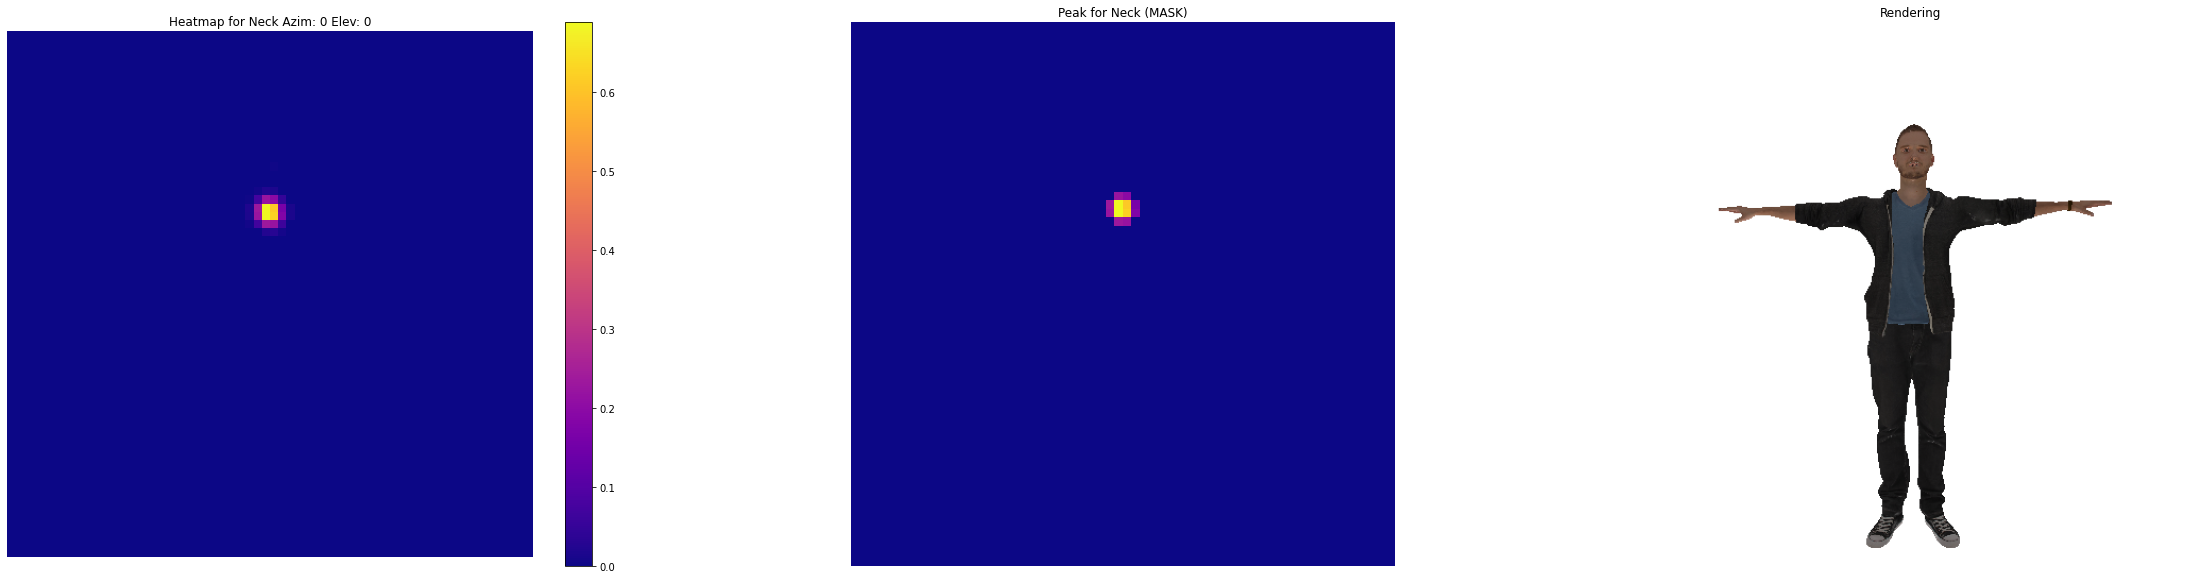

In [9]:
for r_info in rendering_info:
    fig = plt.figure(figsize=(40, 10))
    heatmap = r_info["heat"][0, ATTRIBUTION_INDEX, :, :]
    ax = fig.add_subplot(1, 3, 1)
    pcm = ax.imshow(heatmap,  cmap='plasma')
    ax.axis('off')
    ax.set_title(f'Heatmap for {ATTRIBUTION_NAME} Azim: {r_info["azim"]} Elev: {r_info["elev"]}')
    fig.colorbar(pcm, ax=ax, cmap='plasma')
    
    ax = fig.add_subplot(1, 3, 2)
    pcm = ax.imshow(r_info["peak"],  cmap='plasma')
    ax.axis('off')
    ax.set_title(f'Peak for {ATTRIBUTION_NAME} (MASK)')

    
    rendering = r_info["images"][0,:, :, :3]
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(rendering)
    ax.axis('off')
    ax.set_title('Rendering')
    break

In [10]:
gradients_mean = np.mean(gradients_np, axis = 0)
gradients_mag_mean = np.mean(gradients_mag_np, axis = 0)

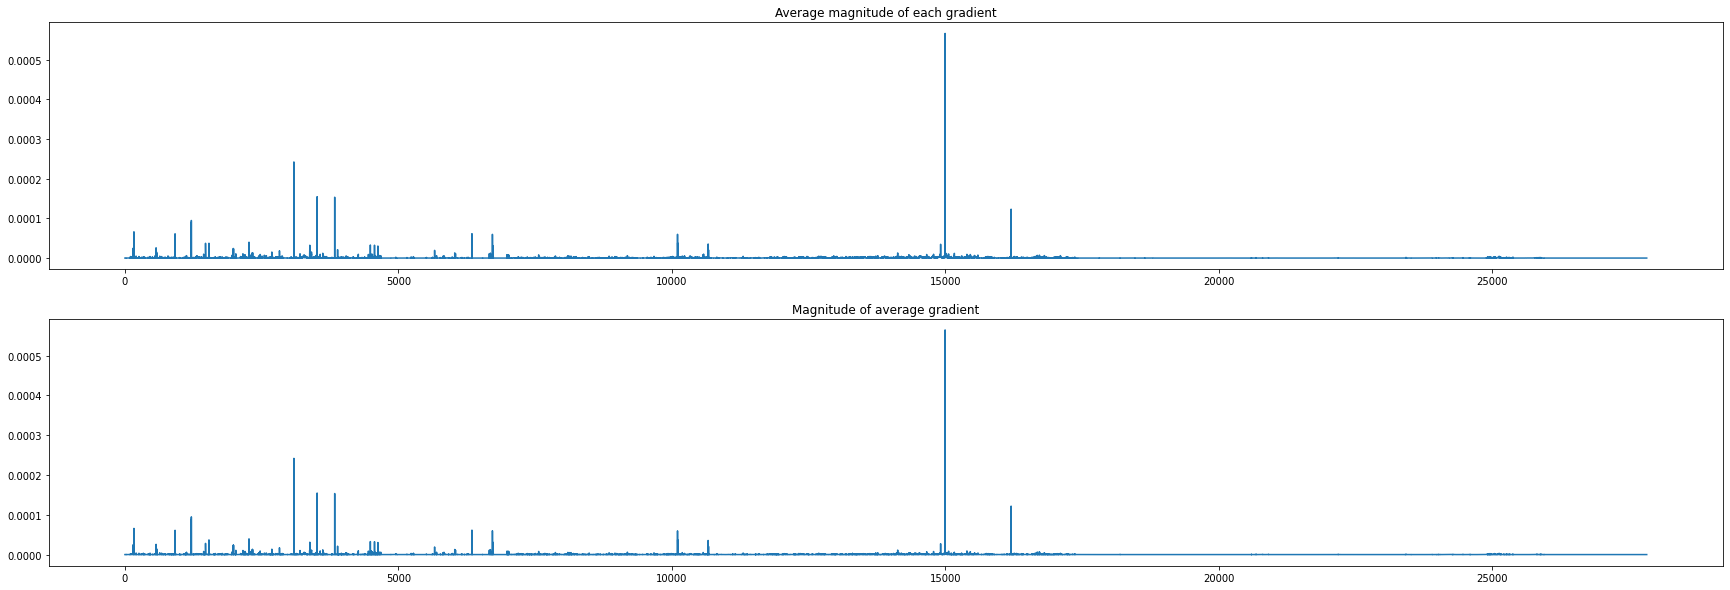

In [11]:
grad_norm = np.linalg.norm(gradients_mean, axis=1)
grad_norm_mag_avg = gradients_mag_mean


fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(2, 1, 1)
ax.plot(grad_norm_mag_avg)
ax.set_title('Average magnitude of each gradient')

ax = fig.add_subplot(2, 1, 2)
ax.plot(grad_norm)
ax.set_title('Magnitude of average gradient')

grad_norm /= 0.00001 # scale up to have a nice vis
grad_norm_mag_avg /= 0.00001 # scale up to have a nice vis

color_map = cm.get_cmap('plasma')

rgb_vertex_colormap = np.array([color_map(grad_norm)[:, :3]], dtype=np.float32)
rgb_vertex_colormap_mag_avg = np.array([color_map(grad_norm_mag_avg)[:, :3]], dtype=np.float32)

In [12]:
verts_rgb = torch.from_numpy(rgb_vertex_colormap).cuda()
verts_rgb_mag_avg = torch.from_numpy(rgb_vertex_colormap_mag_avg).cuda()

R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100

cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

new_texture = Textures(verts_rgb=verts_rgb)
heat_mesh = Meshes(verticies, faces, new_texture)

new_texture_mag_avg = Textures(verts_rgb=verts_rgb_mag_avg)
heat_mesh_mag_avg = Meshes(verticies, faces, new_texture_mag_avg)

heat_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

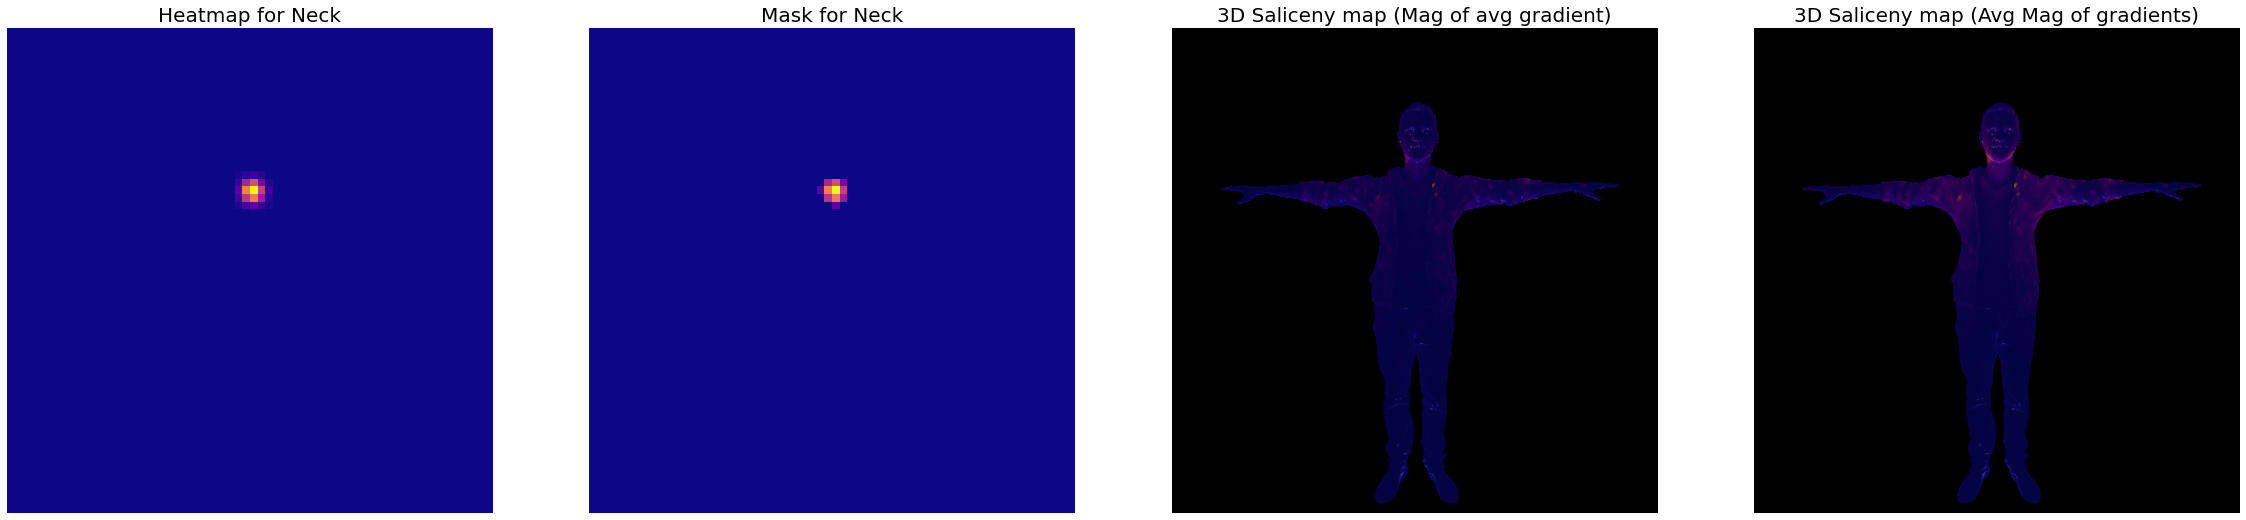

In [13]:
heat_images = heat_renderer(heat_mesh)
heat_images_mag_avg = heat_renderer(heat_mesh_mag_avg)
fontsize=20

heatmap = heat[0, ATTRIBUTION_INDEX, :, :].detach().cpu().numpy()
peak_np = peak_tensor.detach().cpu().numpy()
fig = plt.figure(figsize=(40, 10))

ax = fig.add_subplot(1, 4, 1)
pcm = ax.imshow(heatmap,  cmap='plasma')
ax.axis('off')
ax.set_title(f'Heatmap for {ATTRIBUTION_NAME}', fontsize=fontsize)

ax = fig.add_subplot(1, 4, 2)
pcm = ax.imshow(peak_np,  cmap='plasma')
ax.axis('off')
ax.set_title(f'Mask for {ATTRIBUTION_NAME}', fontsize=fontsize)

ax = fig.add_subplot(1, 4, 3)
ax.imshow(heat_images.detach().cpu().numpy()[0])
ax.axis('off')
ax.set_title('3D Saliceny map (Mag of avg gradient)', fontsize=fontsize)

ax = fig.add_subplot(1, 4, 4)
ax.imshow(heat_images_mag_avg.detach().cpu().numpy()[0])
ax.axis('off')
ax.set_title('3D Saliceny map (Avg Mag of gradients)', fontsize=fontsize)
fig.savefig(f'../results/plots/attri_3d_{ATTRIBUTION_NAME}.png', dpi=100, bbox_inches='tight')

In [14]:
filename_output = f"./gifs/attribution_demo_mv_avg_grad_{ATTRIBUTION_NAME}.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.30)

for rot in tqdm(reversed(range(0, 360, 2))):
    R, T = look_at_view_transform(200.0, 10, rot) 
    T[0, 1] = -100
    heat_images = heat_renderer(meshes_world=heat_mesh, R=R.cuda(), T=T.cuda())
    image = heat_images[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

180it [00:12, 14.74it/s]


![SegmentLocal](gifs/attribution_demo_mv_avg_grad.gif "segment")

In [15]:
filename_output = f"./gifs/attribution_demo_mv_avg_mag_{ATTRIBUTION_NAME}.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.30)

for rot in tqdm(reversed(range(0, 360, 2))):
    R, T = look_at_view_transform(200.0, 10, rot) 
    T[0, 1] = -100
    heat_images = heat_renderer(meshes_world=heat_mesh_mag_avg, R=R.cuda(), T=T.cuda())
    image = heat_images[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

180it [00:13, 13.61it/s]


![SegmentLocal](gifs/attribution_demo_mv_avg_mag.gif "segment")